# Source conditions for linear inverse problems

In [1]:
from matplotlib.pyplot import colorbar, gca, imshow, plot, savefig, subplot, tight_layout
from numpy import linspace, log, mean, ones, ones_like, prod, real, sqrt, \
                    vstack, where, zeros, zeros_like
from numpy import sum as numpy_sum
from numpy.fft import fft2, fftshift, ifft2, ifftshift
from numpy.linalg import norm
from numpy.random import randn
from optimisation import PALM, proximal_gradient_descent, PDHG
from proximal_maps import *
from skimage.color import rgb2gray
from skimage.data import astronaut, shepp_logan_phantom
from skimage import io, img_as_uint
from skimage.transform import resize
from operators import *

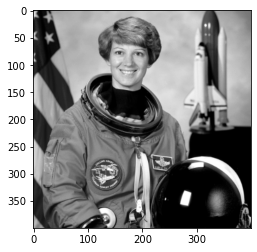

In [2]:
example = 'astronaut' # possible choices: 'shepp_logan', 'astronaut'

if example == 'shepp_logan':
    image = shepp_logan_phantom()
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/shepp_logan_phantom.png', img_as_uint(image))
if example == 'astronaut':
    image = resize(rgb2gray(astronaut()), (400, 400), anti_aliasing=True)
    imshow(image, cmap='gray');
    io.imsave('Data/Images/2DSC/astronaut.png', img_as_uint(image))

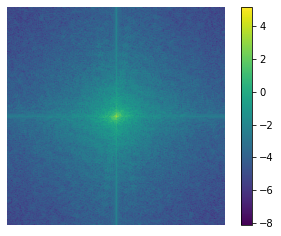

In [3]:
ft_image = fft2(image, norm='ortho')
visual_shift = 0.1/400
imshow(log(visual_shift + abs(fftshift(ft_image))))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_ft.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_ft.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

## Set up sub-sampled Fourier operator

(400, 400)


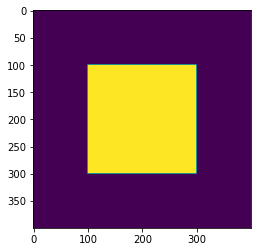

In [4]:
mask = zeros_like(image, dtype=bool)
print(mask.shape)
if example == 'shepp_logan':
    block_dimensions = (slice(135, 265), slice(135, 265))
if example == 'astronaut':
    block_dimensions = (slice(100, 300), slice(100, 300))
mask[block_dimensions] = True
imshow(mask);

In [5]:
K = Fourier_Subsampling(mask)

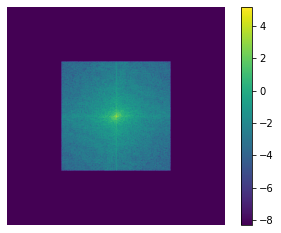

In [6]:
sub_sampled_coefficients = K @ image
imshow(log(visual_shift + abs(sub_sampled_coefficients)))
colorbar();

# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sub_ft.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sub_ft.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

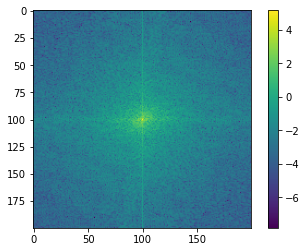

In [7]:
imshow(log(visual_shift + abs(sub_sampled_coefficients[block_dimensions])))
colorbar();

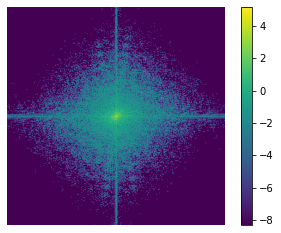

In [8]:
no_of_nonzeros = mask.flatten().sum()
largest_coefficients = l0_bound(fftshift(ft_image), no_of_nonzeros)
imshow(log(visual_shift + abs(largest_coefficients)))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sub_optimal_ft_sampling.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sub_optimal_ft_sampling.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

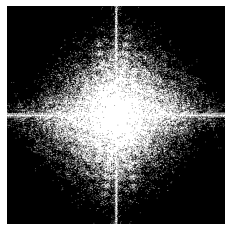

In [9]:
optimal_mask = abs(largest_coefficients) > 0
imshow(optimal_mask, cmap='gray')
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sub_optimal_mask.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sub_optimal_mask.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

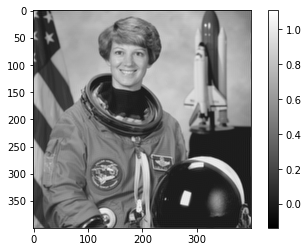

In [10]:
test = (K.T @ (K @ image))
imshow(test, cmap='gray')
colorbar();

In [11]:
G = Difference_Gradient(image.shape)

## Recover source condition element

In [12]:
finite_difference_image = G @ image
step_sizes = [1, 1/9]

proximal_map = lambda argument : argument - l2ball_projection(argument, axis=2)

bregman_gradient_1 = lambda arguments: K @ (K.T @ arguments[0] - G.T @ arguments[1])
bregman_gradient_2 = lambda arguments: G @ (G.T @ arguments[1] - K.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image

In [13]:
def alternating_minimisation(argument1, argument2, gradient1, gradient2, step_sizes, \
                                no_of_iterations=1000, print_output=10000):
    gradient_norm = []
    for counter in range(no_of_iterations):
        gradient_1 = gradient1([argument1, argument2])
        argument1 -= step_sizes[0] * gradient_1
        gradient_2 = gradient2([argument1, argument2])
        argument2 -= step_sizes[1] * gradient_2
        gradient_norm.append(1/2*(norm(gradient_1) + norm(gradient_2)))
        counter += 1
        if counter % print_output == 0:
            print("Iteration no. {i}/{m}, gradient norm = {g}.".format(i = counter, \
                    m=no_of_iterations, g=gradient_norm[-1]))
    return argument1, argument2, gradient_norm

In [14]:
no_of_iterations = 1000

argument1, argument2 = zeros(image.shape, dtype='complex128'), zeros((image.shape[0], \
                                image.shape[1], 2))
argument1, argument2, gradient_norm = alternating_minimisation(argument1, argument2, \
                                        bregman_gradient_1, bregman_gradient_2,
                                        step_sizes, no_of_iterations, print_output=100)

Iteration no. 100/1000, gradient norm = 5.3716047996209575.
Iteration no. 200/1000, gradient norm = 2.847369996004298.
Iteration no. 300/1000, gradient norm = 1.8939099487279398.
Iteration no. 400/1000, gradient norm = 1.405886050278651.
Iteration no. 500/1000, gradient norm = 1.13628874156601.
Iteration no. 600/1000, gradient norm = 0.9585828259898517.
Iteration no. 700/1000, gradient norm = 0.8305058279775048.
Iteration no. 800/1000, gradient norm = 0.7335082581823658.
Iteration no. 900/1000, gradient norm = 0.656139652291787.
Iteration no. 1000/1000, gradient norm = 0.5930808346539729.


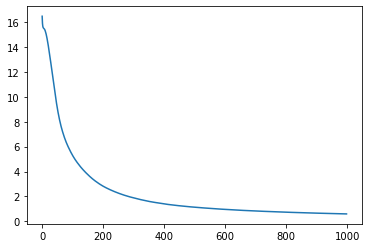

In [15]:
plot(gradient_norm[1:]);

In [16]:
source_condition_element = argument1
print(norm(source_condition_element.reshape(-1)))

255.15003684600313


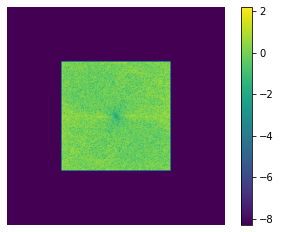

In [17]:
imshow(log(visual_shift + abs(source_condition_element)))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sc_element.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sc_element.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

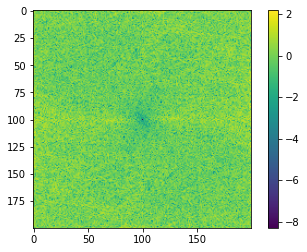

In [18]:
imshow(log(visual_shift + abs(source_condition_element)[block_dimensions]))
colorbar();

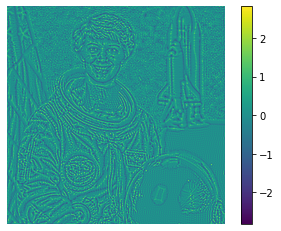

In [19]:
test3 = K.T @ source_condition_element
imshow(test3)
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sc_element_backprojection.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sc_element_backprojection.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [20]:
alpha = 0.5
data = alpha * source_condition_element + K @ image

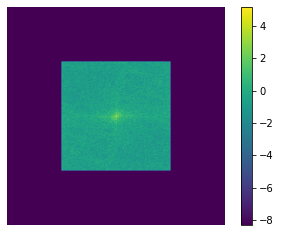

In [21]:
imshow(log(visual_shift + abs(data)))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_range_data.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_range_data.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

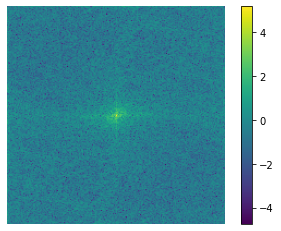

In [22]:
imshow(log(visual_shift + abs(data)[block_dimensions]))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_range_data_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_range_data_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

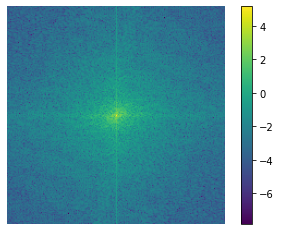

In [23]:
imshow(log(visual_shift + abs(sub_sampled_coefficients[block_dimensions])))
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_data_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_data_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

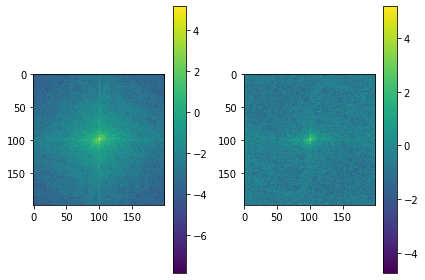

In [24]:
subplot(1, 2, 1)
imshow(log(visual_shift + abs(sub_sampled_coefficients[block_dimensions])))
colorbar()
subplot(1, 2, 2)
imshow(log(visual_shift + abs(data)[block_dimensions]))
colorbar()
tight_layout();

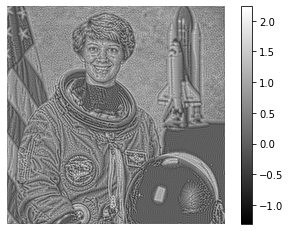

In [25]:
imshow(K.T @ data, cmap='gray')
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_range_data_backprojection.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_range_data_backprojection.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [26]:
print(max(abs(norm(argument2, 2, axis=2)).reshape(-1)))

1.3533024363231676


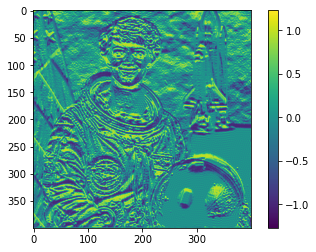

In [27]:
imshow(argument2[:, :, 1])
colorbar();

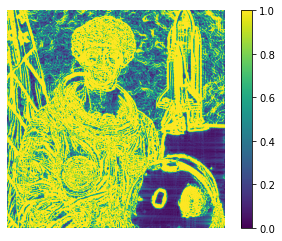

In [28]:
imshow(sqrt(argument2[:, :, 0] ** 2 + argument2[:, :, 1] ** 2), vmin=0, vmax=1)
colorbar();
# Save image
ax = gca()
ax.set_axis_off()
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_subgradient.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_subgradient.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

## PDHG Sanity Check

In [29]:
step_sizes = [1/8, 1]
F = Fourier_Transform()
primal_proximal_map = lambda argument : subsampled_fourier_prox(argument, mask, F, data, \
                                            step_sizes[0]/alpha)
dual_proximal_map = lambda argument : l2ball_projection(argument, axis=2)
proximal_maps = [primal_proximal_map, dual_proximal_map]
initial_arguments = [zeros_like(image), zeros_like(argument2)]

In [30]:
max_no_of_iterations=1000
tolerance=1e-6
print_output=100

arguments, norm_list = PDHG(G, proximal_maps, initial_arguments, step_sizes, \
                            max_no_of_iterations, print_output, tolerance)

Iteration 100/1000, sensitivity = 0.001959935313353041.
Iteration 200/1000, sensitivity = 0.0008438784149532241.
Iteration 300/1000, sensitivity = 0.000491449344401576.
Iteration 400/1000, sensitivity = 0.0003363659071716438.
Iteration 500/1000, sensitivity = 0.0002476611639951318.
Iteration 600/1000, sensitivity = 0.00019296867643047444.
Iteration 700/1000, sensitivity = 0.00015624339328797768.
Iteration 800/1000, sensitivity = 0.000128440212971592.
Iteration 900/1000, sensitivity = 0.0001084258080656617.
Iteration 1000/1000, sensitivity = 9.292893688870623e-05.
Iteration completed after 1000/1000, sensitivity = 9.292893688870623e-05.


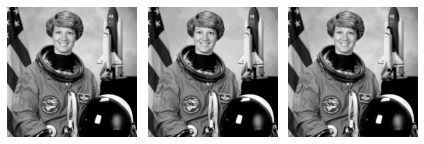

In [31]:
subplot(1, 3, 1)
imshow(image, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(1, 3, 2)
imshow(arguments[0], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(1, 3, 3)
imshow(test, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sanity_check.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sanity_check.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

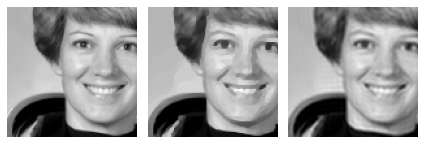

In [32]:
if example == 'shepp_logan':
    window = (slice(300, 350), slice(150, 250))
if example == 'astronaut':
    window = (slice(50, 150), slice(100, 200))
subplot(1, 3, 1)
imshow(image[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(1, 3, 2)
imshow(arguments[0][window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(1, 3, 3)
imshow(test[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sanity_check_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sanity_check_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

# Learning the optimal sampling pattern

In [33]:
if example == 'shepp_logan':
    threshold = 0.1
if example == 'astronaut':
    threshold = 0.24
l1_proximal_map = lambda argument : soft_thresholding(argument, threshold/9)
identity_proximal_map = lambda argument : argument
proximal_maps = [l1_proximal_map, identity_proximal_map]
bregman_gradient_1_new = lambda arguments: F @ (F.T @ arguments[0] - G.T @ arguments[1])
bregman_gradient_2_new = lambda arguments: G @ (G.T @ arguments[1] - F.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
gradients = [bregman_gradient_1_new, bregman_gradient_2_new]

In [34]:
no_of_iterations = 1000
step_sizes = [1, 1/9]
palm_arguments = [zeros(image.shape, dtype='complex128'), zeros((image.shape[0], \
                                image.shape[1], 2))]                
palm_arguments, norm_list = PALM(gradients, proximal_maps, palm_arguments, step_sizes, \
                            no_of_iterations, print_output=100)                      

/data/home/ahw696/SC-3/proximal_maps.py:27: RuntimeWarning: invalid value encountered in true_divide
  output = argument/abs(argument) * (abs(argument) - threshold).clip(0)


Iteration 100/1000, sensitivity = 0.012241024059020892.
Iteration 200/1000, sensitivity = 0.005135675383064479.
Iteration 300/1000, sensitivity = 0.0030320497072501445.
Iteration 400/1000, sensitivity = 0.0020899196687665512.
Iteration 500/1000, sensitivity = 0.0015647917817227745.
Iteration 600/1000, sensitivity = 0.001238509236627251.
Iteration 700/1000, sensitivity = 0.0010160059928660033.
Iteration 800/1000, sensitivity = 0.0008557121092803476.
Iteration 900/1000, sensitivity = 0.0007366658157358539.
Iteration 1000/1000, sensitivity = 0.0006442978815644116.
Iteration completed after 1000/1000, sensitivity = 0.0006442978815644116.


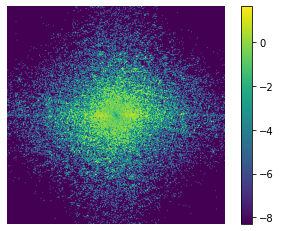

In [35]:
imshow(log(visual_shift + abs(palm_arguments[0])))
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

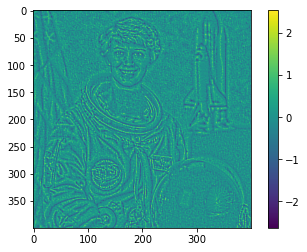

In [36]:
imshow(F.T @ palm_arguments[0])
colorbar();

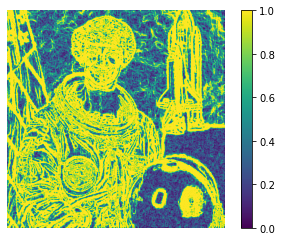

In [37]:
imshow(sqrt(palm_arguments[1][:, :, 0] ** 2 + palm_arguments[1][:, :, 1] ** 2), vmin=0, vmax=1)
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sc_subgradient.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sc_subgradient.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

205.9323367190563
38262 40000


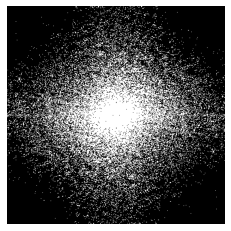

In [38]:
new_source_condition_element = palm_arguments[0]
print(norm(new_source_condition_element.reshape(-1)))
abs_sc_elem = abs(new_source_condition_element)
new_mask = abs_sc_elem > 0
new_mask[200, 200] = True
imshow(new_mask, cmap='gray');
print(new_mask.sum(), no_of_nonzeros)
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_mask.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_mask.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

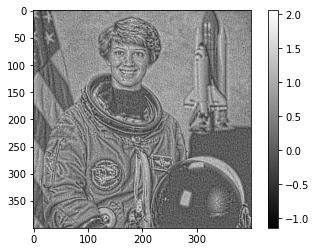

In [39]:
K_new = Fourier_Subsampling(new_mask)
new_data = alpha * palm_arguments[0] + K_new @ image
imshow(K_new.T @ new_data, cmap='gray')
colorbar();

In [40]:
step_sizes = [1, 1/9]
new_bregman_gradient_1 = lambda arguments: K_new @ (K_new.T @ arguments[0] - G.T @ arguments[1])
new_bregman_gradient_2 = lambda arguments: G @ (G.T @ arguments[1] - K_new.T @ arguments[0]) + \
                        proximal_map(arguments[1] + finite_difference_image) - finite_difference_image
no_of_iterations = 1000
new_argument1, new_argument2, gradient_norm = alternating_minimisation(palm_arguments[0], \
                                        palm_arguments[1], new_bregman_gradient_1, \
                                        new_bregman_gradient_2, step_sizes, no_of_iterations, \
                                        print_output=100)

Iteration no. 100/1000, gradient norm = 1.6015808341841868.
Iteration no. 200/1000, gradient norm = 1.1453913960329651.
Iteration no. 300/1000, gradient norm = 0.9013769497025346.
Iteration no. 400/1000, gradient norm = 0.7427925289171341.
Iteration no. 500/1000, gradient norm = 0.6311823452700734.
Iteration no. 600/1000, gradient norm = 0.5488802685923873.
Iteration no. 700/1000, gradient norm = 0.4845275061274681.
Iteration no. 800/1000, gradient norm = 0.43196861565073874.
Iteration no. 900/1000, gradient norm = 0.38874065215255704.
Iteration no. 1000/1000, gradient norm = 0.35270747361837546.


302.4659029626773


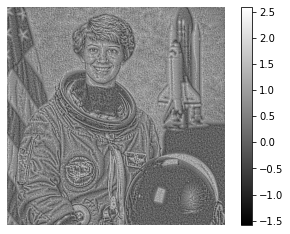

In [41]:
print(norm(new_argument1.reshape(-1)))
new_data = alpha * new_argument1 + K_new @ image
imshow(K_new.T @ new_data, cmap='gray')
colorbar();
ax = gca()
ax.set_axis_off()
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_rc_data_backprojection.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_rc_data_backprojection.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

In [42]:
step_sizes = [1/8, 1]
primal_proximal_map = lambda argument : subsampled_fourier_prox(argument, new_mask, F, new_data, \
                                            step_sizes[0]/alpha)
proximal_maps = [primal_proximal_map, dual_proximal_map]                                            
max_no_of_iterations=1000
tolerance=1e-6
print_output=100
new_arguments, norm_list = PDHG(G, proximal_maps, initial_arguments, step_sizes, \
                            max_no_of_iterations, print_output, tolerance)

Iteration 100/1000, sensitivity = 0.0021428795832830632.
Iteration 200/1000, sensitivity = 0.0008247892042983039.
Iteration 300/1000, sensitivity = 0.000440344955181192.
Iteration 400/1000, sensitivity = 0.00030078899776966606.
Iteration 500/1000, sensitivity = 0.00019889085384111417.
Iteration 600/1000, sensitivity = 0.00015253457157916333.
Iteration 700/1000, sensitivity = 0.00011455456631123733.
Iteration 800/1000, sensitivity = 9.564646348633461e-05.
Iteration 900/1000, sensitivity = 7.756645419735649e-05.
Iteration 1000/1000, sensitivity = 6.709327071487889e-05.
Iteration completed after 1000/1000, sensitivity = 6.709327071487889e-05.


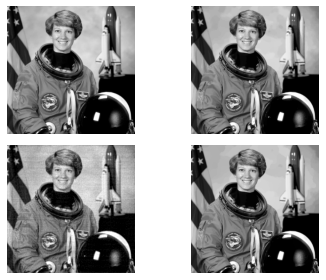

In [43]:
test2 = K_new.T @ (K_new @ image)
subplot(2, 2, 1)
imshow(image, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2, cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(arguments[0], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)

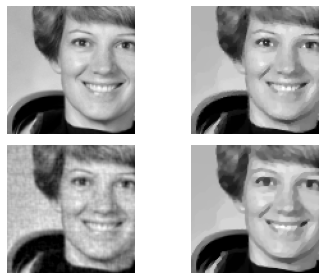

In [44]:
if example == 'shepp_logan':
    window = (slice(300, 350), slice(150, 250))
if example == 'astronaut':
    window = (slice(50, 150), slice(100, 200))
subplot(2, 2, 1)
imshow(image[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 2)
imshow(new_arguments[0][window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 3)
imshow(test2[window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
subplot(2, 2, 4)
imshow(arguments[0][window], cmap='gray', vmin=0, vmax=1)
ax = gca()
ax.set_axis_off()
tight_layout();
# Save image
if example == 'shepp_logan':
    path = 'Data/Images/2DSC/shepp_logan_sparse_sanity_check_closeup.png'
if example == 'astronaut':
    path = 'Data/Images/2DSC/astronaut_sparse_sanity_check_closeup.png'
savefig(path, dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1)